In [1]:
import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities 
from qiskit.compiler import transpile 
from qiskit.providers.ibmq.managed import IBMQJobManager 
from qiskit.providers.aer.noise import NoiseModel 

Load your IBM account.

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

Select your backend.

In [3]:
backend = provider.get_backend('ibmq_quito')
simulator = Aer.get_backend('aer_simulator')
noise_model = NoiseModel.from_backend(backend)

Initialize the class for the QND-measurement tomography of the backend. 

In [4]:
qndmt = device_process_measurement_tomography( backend )

Create the circuits.

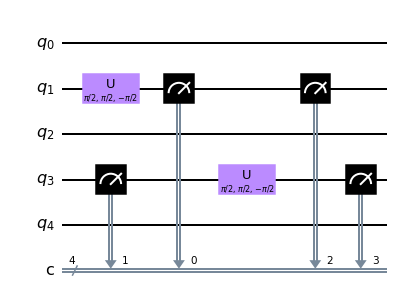

In [5]:
circuits_qndmt = qndmt.circuits()
circuits_qndmt[300].draw(output='mpl')

Run the circuits on the backend. We recommend using job_manager because the number of circuits needed for the tomography easily exceeds the maximum allowed by the backends. This splits the circuits in smaller groups and creates a set of jobs.

In [6]:
# job_manager = IBMQJobManager()
# job = job_manager.run( transpile( circuits_qndmt, backend ) , backend=backend, shots=2**13 )
# job.statuses() 

We also recommend saving the id the job. Using this id we can easily retrieve the experimental results.

In [7]:
# job_id = job.job_set_id()
# job_id 

This can be done with the following sentence.

In [8]:
# job = job_manager.retrieve_job_set( job_id, provider )

The results of the set of jobs can be combined into a single one.

In [9]:
# results = job.results().combine_results()

For simulations simply use the standard run function.

In [10]:
job = simulator.run( circuits_qndmt, noise_model=noise_model )
results = job.result()

We perform the post-processing of the experimental data to obtain the estimated Choi matrices. The argument "paralell=True" allows to use multicore for the post-processing, while "gate_set=True" mitigate the initialization and gate errors with gate set tomography. 

In [12]:
results_tomography = qndmt.fit( results, paralell=True, gate_set=True ) 
results_single     = results_tomography.single 
results_double     = results_tomography.double 
results_gateset    = results_tomography.gateset 

In [32]:
choi_single = results_single.chois
povm_single = results_single.povms
choi_double = [ results.chois for results in results_double ]
povm_double = [ results.povms for results in results_double ]

The QND-MT class save information about de the device, such as the number of qubit and the groups of the parallelization.

In [23]:
num_qubits    = qndmt._num_qubits
parall_qubits = qndmt._parall_qubits

print( num_qubits )
print( parall_qubits )

5
[[(1, 3)], [(0, 1), (3, 4)], [(1, 2)]]


The estimated choi matrices can be used for compute the readout fidelity, qndness, destructiviness, and the cross-quantities. 

In [35]:
quantities = []
for k in range(num_qubits):
    quantities.append( Quantities( povm_single[k] , choi_single[k] ) )

quantities_2 = []
cros_quantities = []
for i in range(len(parall_qubits)):
    for j in range(len(parall_qubits[i])):
        k = parall_qubits[i][j][0]
        l = parall_qubits[i][j][1]
        cros_quantities.append( Cross_Quantities( povm_single[k], choi_single[k],
                                                  povm_single[l], choi_single[l],
                                                  povm_double[i][j], choi_double[i][j]
                                                )  )
        quantities_2.append( Quantities( povm_double[i][j], choi_double[i][j] ) )

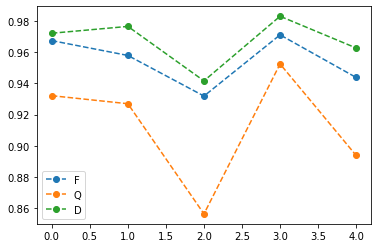

In [36]:
plt.plot( quantities, '--o' )
plt.legend( ['F','Q', 'D'] )

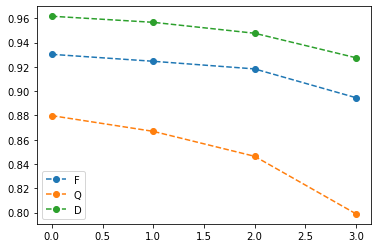

In [37]:
plt.plot( quantities_2, '--o' )
plt.legend( ['F','Q', 'D'] )

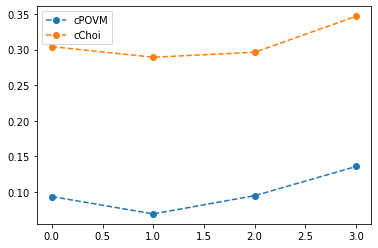

In [38]:
plt.plot( np.array(cros_quantities), '--o' )
plt.legend( ['cPOVM','cChoi'] )